In [11]:
import torch
import torch.nn as nn

import os
import numpy as np
import pandas as pd

In [12]:
SP500 = './stock_market_data/sp500/csv/'
FILES = [os.path.join(SP500, file) for file in os.listdir(SP500)]
EXCEPTIONS = []
TIME_D = 10

In [13]:
BATCH_SIZE = 128
DEVICE = "cuda"
EPOCHS = 10
AS_DOUBLE = False
WAB = False
LR = 1e-3

In [14]:
from torch.utils import data
from sklearn.model_selection import train_test_split

In [15]:
def scale(X, y):
    div = 255 / np.max(X)
    X *= div
    y *= div
    return X, y

In [16]:
def make_dataset(df: pd.DataFrame, time_d: int = 10):
    X, y = [], []
    last = []
    for i, row in df.iterrows():
        if row.hasnans:
            if type(last) == type(None):
                continue
            row = last[-1] + (last[-1] - last[len(last) - 2]) / 2


        if type(last) == type(None) or len(last) < time_d:
            last.append(row.values)
            continue
        
        X.append(np.array(last))
        y.append(row.values)
        last.pop(0)
        last.append(row.values)

    return np.array(X), np.array(y)

In [17]:
def get_loader_for_file(path: str):
    df = pd.read_csv(path)
    df.drop(['Date'], axis=1, inplace=True)
    X, y = make_dataset(df, TIME_D)
    X, y = scale(X, y)
    if not AS_DOUBLE:
        X, y = X.astype("float32"), y.astype("float32")
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    train_loader = data.DataLoader(data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=BATCH_SIZE)
    test_loader = data.DataLoader(data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=BATCH_SIZE)

    return train_loader, test_loader

In [18]:
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res

In [19]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, **kwargs):
        super(CNNBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, kernel_size=kernel_size, stride=stride, padding=padding, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

    def outshape(self, w, h):
        return int((h + 2 * self.padding - 1 * (self.kernel_size - 1) - 1) / self.stride + 1), int((w + 2 * self.padding - 1 * (self.kernel_size - 1) - 1) / self.stride + 1)

In [20]:
class ConvLSTM(nn.Module):
    def __init__(self, time_d: int = 10, n_outputs: int = 6):
        super(ConvLSTM, self).__init__()
        self.time_d = time_d
        self.n_outputs = n_outputs
        self.dropout = 0.1
        self.n_filters = 32

        self.cnn = CNNBlock(
                    1,        # channels
                    out_channels=self.n_filters,  # filters
                    kernel_size=2,   # kernel size
                    stride=2,        # stride
                    padding=3,       # padding
            )
        self.cnn_bn = nn.BatchNorm2d(self.n_filters)

        self.lstm = nn.LSTM(time_d, n_outputs, 2)
        self.lstm_bn = nn.BatchNorm1d(n_outputs)

        self.mid_neurons = (self.n_outputs ** 2) + (self.n_filters * prod(self.cnn.outshape(self.n_outputs, self.time_d)))
        self.final = self._create_output_layers()

    def _create_output_layers(self):
        return nn.Sequential(
            nn.Linear(self.mid_neurons, self.time_d * self.n_outputs),
            nn.Dropout(self.dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(self.time_d * self.n_outputs, self.n_outputs)
        )

    def forward(self, x):
        xa, (h_n, c_n) = self.lstm(x.reshape(-1, self.n_outputs, self.time_d))
        xa = self.lstm_bn(xa)

        xb = self.cnn(x.reshape(-1, 1, self.time_d, self.n_outputs))
        xb = self.cnn_bn(xb)

        xa = xa.reshape(-1, self.n_outputs * self.n_outputs)
        xb = xb.reshape(-1, self.n_filters * prod(self.cnn.outshape(self.n_outputs, self.time_d)))

        x = torch.hstack((xa, xb))

        # forward through output layers and return
        return self.final(x)

In [21]:
class ConvLSTMLoss(nn.Module):
    def __init__(self):
        super(ConvLSTMLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

    def forward(self, pred, target):
        loss = self.mse(pred, target)
        return loss

In [22]:
m = ConvLSTM(TIME_D, 6).to(DEVICE)
if AS_DOUBLE:
    m = m.double()

In [23]:
from tqdm import tqdm

In [24]:
loss_fn = ConvLSTMLoss()
opt = torch.optim.Adam(m.parameters(), lr=LR)

In [25]:
def train_fn(loader):
    losses = []

    for x, y in loader:            
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = m(x)
        loss = loss_fn(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    if WAB:
        wandb.log({"loss": int(np.mean(losses))})

    return int(np.mean(losses))

In [26]:
def train():
    for epoch in range(EPOCHS):
        loop = tqdm(enumerate(FILES), total=len(FILES), leave=True)
        for i, path in loop:
            if path in EXCEPTIONS:
                continue

            try:
                train_loader, _ = get_loader_for_file(path)
                mean_loss = train_fn(train_loader)
                loop.set_postfix(loss=mean_loss) # update progress bar
            except:
                print(f'Something went wrong when processing file {path}. Adding it to the exceptions.')
                EXCEPTIONS.append(path)
                continue

In [16]:
import wandb



 12%|█▏        | 50/413 [01:12<08:54,  1.47s/it, loss=14289]

Something went wrong when processing file ./stock_market_data/sp500/csv/BEN.csv. Adding it to the exceptions.


 12%|█▏        | 51/413 [01:14<10:24,  1.72s/it, loss=3798] 

Something went wrong when processing file ./stock_market_data/sp500/csv/BHI.csv. Adding it to the exceptions.


 14%|█▍        | 57/413 [01:23<09:15,  1.56s/it, loss=2106]

In [ ]:
train()

In [ ]:
wandb.finish()

loss,█▆▆▅▅▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁
loss,673


In [27]:
def sweep():
    with wandb.init(project='Stonks', entity="seppedelanghe") as run:
        config = wandb.config
        LR = config['lr']
        TIME_D = config['time_d']

        for epoch in range(config['epochs']):
            loop = tqdm(enumerate(FILES), total=len(FILES), leave=True)
            for i, path in loop:
                if path in EXCEPTIONS:
                    continue

                try:
                    train_loader, _ = get_loader_for_file(path)
                    mean_loss = train_fn(train_loader)
                    loop.set_postfix(loss=mean_loss) # update progress bar
                except:
                    print(f'Something went wrong when processing file {path}. Adding it to the exceptions.')
                    EXCEPTIONS.append(path)
                    continue

In [28]:
import wandb

sweep_config = {
  "name" : "initial-sweep",
  "method" : "random",
  "parameters" : {
    "epochs" : {
      "values" : [2, 3, 4, 5]
    },
    "lr" :{
      "min": 0.0001,
      "max": 0.1
    },
    "time_d": {
        "min": 3,
        "max": 15
    }
  }
}

sweep_id = wandb.sweep(sweep_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 9j4my0r7
Sweep URL: https://wandb.ai/seppedelanghe/uncategorized/sweeps/9j4my0r7


In [30]:
wandb.agent(sweep_id, function=sweep, count=1)

wandb: Agent Starting Run: 07i1o23r with config:
wandb: 	epochs: 3
wandb: 	lr: 0.040622029510542584
wandb: 	time_d: 12
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


 13%|█▎        | 54/413 [01:19<09:52,  1.65s/it, loss=3211] 

In [ ]:
def test_fn(loader):
    results = None

    for x, y in loader:
        x = x.to(DEVICE)
        y_pred = m(x)
        
        y_pred = y_pred.to('cpu').detach().numpy()
        y = y.to('cpu').detach().numpy()
        if type(results) == type(None):
            results = np.array((y, y_pred))
        else:
            results = np.hstack((results, np.array((y, y_pred))))

    return results.reshape((results.shape[1], 2, results.shape[-1]))

In [ ]:
_, test_loader = get_loader_for_file(FILES[0])
results = test_fn(test_loader)    

In [ ]:
results.shape

(569, 2, 6)

In [ ]:
results[0]

array([[9.99996116e-05, 1.02332646e-04, 1.17280900e+01, 1.04111587e-04,
        1.00582874e-04, 9.14977158e-05],
       [5.15411116e-04, 5.20915026e-04, 6.57249069e+00, 5.25032779e-04,
        5.17775769e-04, 5.13273684e-04]])

In [ ]:
import matplotlib.pyplot as plt

[[ 0  0 17  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0 10  0  0  0]]
[[ 0  0 10  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  6  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  6  0  0  0]
 [ 0  0  4  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0  8  0  0  0]]
[[ 0  0 16  0  0  0]
 [ 0  0 21  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0 24  0  0  0]
 [ 0  0 69  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0 19  0  0  0]]
[[ 0  0 12  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0 29  0  0  0]
 [ 0  0 14  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  8  0  0  0]]
[[ 0  0  7  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  7  0  0  0]
 [ 0  0 14  0  0  0]
 [ 0  0 13  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0 10  0  0  0]
 [ 0  0  

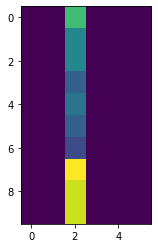

In [ ]:
for x, y in test_loader:
    x = x.detach().numpy()
    x = np.rint(x).astype('uint8')
    for i in range(len(x)):
        if i > 5:
            break
        
        bx, by = x[i], y[i]
        print(bx)
        plt.imshow(bx)
        
    break

In [ ]:
torch.save(m.state_dict(), './sp500_413_loss_688.tar.pth')

In [ ]:
model = ConvLSTM()
model.load_state_dict(torch.load('./sp500_413_loss_688.tar.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

ConvLSTM(
  (cnn): CNNBlock(
    (conv): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2), padding=(3, 3), bias=False)
    (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leakyrelu): LeakyReLU(negative_slope=0.1)
  )
  (cnn_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(10, 6, num_layers=2)
  (lstm_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Sequential(
    (0): Linear(in_features=1572, out_features=60, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=60, out_features=6, bias=True)
  )
)